In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from Bio import Entrez
from tqdm import tqdm
import pickle
from pickle5 import pickle

In [15]:
data = pd.read_csv (r'data/SFARI-Genes.csv')
cols = data.columns
N, D = data.shape

In [16]:
gene2go = open_pickle_file("gene2go.pickle")
eid = parse_eid()
gene_symbols = data['gene-symbol'].unique()

In [5]:
def save_to_txt_file(contents, filename):
    DIR = os.getcwd() + "/results/" + filename
    
    with open(DIR, "w") as f:
        f.write(contents)
        
def save_to_pickle_file(contents, filename):
    DIR = os.getcwd() + "/data/" + filename
    
    with open(DIR, "wb") as handle:
        pickle.dump(contents, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def open_pickle_file(filename):
    DIR = os.getcwd() + "/data/" + filename
    
    with open(DIR, "rb") as handle:
        data = pickle.load(handle)
        
    return data

def save_to_npy_file(contents, filename):
    np.save(os.getcwd() + "/data/" + filename, contents)
    
def open_npy_file(filename):
    np.load(os.getcwd() + "/data/" + filename, allow_pickle=True)
    
def parse_eid():
    DIR = os.getcwd() + "/results/task2-1-eid.txt"
    eid = {}
    
    with open(DIR) as f:
        lines = f.readlines()
        
    for l in lines:
        t1 = l.replace("\n", "").split(": ")
        gene = t1[0]

        if len(t1) > 1:
            eid[gene] = t1[1].split(", ")
        else:
            eid[gene] = ""
               
    return eid

def get_entrezs(symbols):
    entrezs = {}
    
    for s in symbols:
        entrezs[s] = eid[s]
        
    return entrezs

def get_GO_indexes(symbols):
    indexes = {}
    entrezs = get_entrezs(symbols)
    errors = 0
    
    tax_ids = gene2go["#tax_id"]
    human_gene_indexes = tax_ids[tax_ids == "9606"].index
    human_genes = gene2go.filter(items=human_gene_indexes, axis = 0)
    human_gene_ids = human_genes["GeneID"]

    for g in tqdm(gene_symbols):
        gene_entrez = eid[g]

        if len(gene_entrez) == 0:
            print(g)
            continue
        else:
            gene_entrez = gene_entrez[0]

        gene_index = human_gene_ids[human_gene_ids == gene_entrez].index.unique()

        indexes[g] = gene_index
    
    if errors > 0:
        print("Warning {} errors exist".format(errors))
        
    return indexes

def get_GO_cols(cols, indexes):
    cols_data = []
    output = []
    
    for c in cols:
        cols_data.append(gene2go[c].filter(items=indexes, axis=0))
    
    ids = cols_data[0].values
    descs = cols_data[1].values

    assert(len(ids) == len(descs))

    for i in range(len(ids)):
        output.append([ids[i], descs[i]])
    
    return output

In [18]:
genes_no_ids = ["MSNP1AS", "RP11-1407O15.2", "RPS10P2-AS1"]
symbol_data = data["gene-symbol"]
indexes = []

for g in genes_no_ids:
    index = symbol_data[symbol_data == g].index[0]
    indexes.append(index)
    
new_data = data.filter(items=indexes, axis=0)
print(indexes)
display(new_data)

[576, 771, 790]


,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
576,9,MSNP1AS,"Moesinpseudogene 1, antisense",NaN,5,"Genetic Association, Functional",2.0,0,13
771,9,RP11-1407O15.2,NaN,NaN,17,Rare Single Gene Mutation,3.0,0,1
790,9,RPS10P2-AS1,ribosomal protein S10 pseudogene 2 anti-sense 1,NaN,20,"Genetic Association, Functional",2.0,0,4


In [7]:
symbol_data[771]

'RP11-1407O15.2'

# Task 1

In [4]:
gene_symbols = data['gene-symbol'].unique()
print(gene_symbols.size)

1023


In [5]:
# Save Entrez scores

In [96]:
Entrez.email = "s1803764@ed.ac.uk"
output = ""
eid = {}

for i in tqdm(range(gene_symbols.size)):
    g = gene_symbols[i]
    handle = Entrez.esearch(db="gene", retmax=10, term=g + "[sym] homo sapiens[Organism]")
    record = Entrez.read(handle)
    
    if len(record['IdList']) > 0:
        output += g + ": " + record['IdList'][0]
        output += "\n"
        eid[g] = record['IdList'][0]
    else:
        eid[g] = ""
        output += g +": \n"
    
save_to_txt_file(output, "task2-1-eid.txt")

100%|███████████████████████████████████████| 1023/1023 [10:30<00:00,  1.62it/s]


# Task 2

In [74]:
gene2go = pd.read_csv(os.getcwd() + "/data/gene2go", dtype=str, delimiter="\t")
save_to_pickle_file(gene2go, "gene2go.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/home/hwixley/Documents/4th-Year/BI/cwk2/code/data/gene2go'

In [75]:
gene2go

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
0,3702,814629,GO:0005634,ISM,located_in,nucleus,-,Component
1,3702,814629,GO:0008150,ND,involved_in,biological_process,-,Process
2,3702,814630,GO:0003700,ISS,enables,DNA-binding transcription factor activity,11118137,Function
3,3702,814630,GO:0005634,ISM,located_in,nucleus,-,Component
4,3702,814630,GO:0006355,TAS,acts_upstream_of_or_within,"regulation of transcription, DNA-templated",11118137,Process
...,...,...,...,...,...,...,...,...
2084173,559292,65052912,GO:0005575,ND,is_active_in,cellular_component,-,Component
2084174,559292,65052912,GO:0008150,ND,involved_in,biological_process,-,Process
2084175,559292,65052913,GO:0003674,ND,enables,molecular_function,-,Function
2084176,559292,65052913,GO:0005575,ND,is_active_in,cellular_component,-,Component


In [97]:
gene2go = open_pickle_file("gene2go.pickle")
eid = parse_eid()

ABAT
ABCA10
ABCA13
ABCA7
ACE
ACHE
ACTB
ACTL6B
ACTN4
ACY1
ADA
ADCY3
ADCY5
ADK
ADNP
ADORA3
ADSL
AFF2
AGAP1
AGAP2
ADSS2
AGBL4
AGMO
AGO1
AGO3
AGO4
AGTR2
AHDC1
AHI1
AKAP9
ALDH1A3
ALDH5A1
AMPD1
AMT
ANK2
ANK3
ANKRD11
AGAP5
AGO2
AHNAK
ANKRD17
ANKS1B
ANXA1
AP1S2
APBA2
APBB1
APH1A
ARHGAP11B
ARHGAP32
ARHGAP5
ARHGEF10
ARHGEF9
ARID1B
ARID2
ARNT2
ARX
ASAP2
ASB14
ASH1L
ASMT
ASPM
ASTN2
ASXL3
ATP10A
ATP1A1
ATP1A3
ATP2B2
ATP6V0A2
ATRX
AUTS2
ADORA2A
AP2S1
AVPR1A
AZGP1
BAZ2B
BBS4
BCAS1
BCKDK
BCL11A
ADRB2
ALG6
AR
AVPR1B
BCORL1
BIRC6
BRAF
BRCA2
BRD4
BRSK2
BRWD3
BST1
BTAF1
BTRC
C12orf57
C15orf62
C4B
CA6
CACNA1A
CACNA1B
CACNA1C
CACNA1D
CACNA1E
CACNA1F
CACNA1G
CACNA1H
CACNA1I
CACNA2D1
CACNA2D3
CACNB2
CADM1
CADM2
CADPS
CADPS2
CAMK2A
CAMK2B
CAMK4
CAPN12
CAPRIN1
CARD11
CASK
CASZ1
CC2D1A
CCDC88C
CCDC91
CCIN
CCNG1
CCNK
CCSER1
CCT4
CD276
CD38
CDC42BPB
BRINP3
CACNB1
CD99L2
CDH10
CDH11
CDH13
CDH22
CDH8
CDH9
CDK13
CDK19
CDK8
CDKL5
BICRA
BICDL1
CECR2
CELF4
CELF6
CEP135
CEP290
CEP41
CGNL1
CHAMP1
CHD1
CHD2
CHD3
CHD7
CHD8


In [98]:
eid["MSNP1AS"]

['']

In [99]:
go_terms = {}

errors = 0

tax_ids = gene2go["#tax_id"]
human_gene_indexes = tax_ids[tax_ids == "9606"].index
human_genes = gene2go.filter(items=human_gene_indexes, axis = 0)
human_gene_ids = human_genes["GeneID"]
#print(human_gene_indexes.size)

for g in tqdm(gene_symbols):
    gene_entrez = eid[g]
    
    if len(gene_entrez) == 0:
        break
    else:
        gene_entrez = gene_entrez[0]

    gene_index = human_gene_ids[human_gene_ids == gene_entrez].index.unique()
    
    if gene_index.size >= 1:
        if not gene_index[0] in human_gene_indexes:
            errors += 1
            continue
        else:
            gene_index = int(gene_index[0])

    go_term = gene2go.iloc[gene_index]["GO_term"]
    go_terms[g] = go_term

save_to_pickle_file(go_terms, "go-terms.pickle")

100%|███████████████████████████████████████| 1023/1023 [00:10<00:00, 95.67it/s]


In [95]:
human_gene_indexes

Int64Index([643502, 643503, 643504, 643505, 643506, 643507, 643508, 643509,
            643510, 643511,
            ...
            974915, 974916, 974917, 974918, 974919, 974920, 974921, 974922,
            974923, 974924],
           dtype='int64', length=331423)

In [100]:
go_terms

{'ABAT': 'response to hypoxia',
 'ABCA10': 'lipid transporter activity',
 'ABCA13': 'lipid transporter activity',
 'ABCA7': 'Golgi membrane',
 'ACE': 'kidney development',
 'ACHE': 'acetylcholine catabolic process in synaptic cleft',
 'ACTB': 'regulation of cyclin-dependent protein serine/threonine kinase activity',
 'ACTL6B': 'chromatin binding',
 'ACTN4': 'RNA polymerase II transcription regulatory region sequence-specific DNA binding',
 'ACY1': 'aminoacylase activity',
 'ADA': 'allantoin metabolic process',
 'ADCY3': 'adenylate cyclase activity',
 'ADCY5': 'G protein-coupled adenosine receptor signaling pathway',
 'ADK': 'RNA binding',
 'ADNP': 'chromatin',
 'ADORA3': 'G protein-coupled adenosine receptor activity',
 'ADSL': 'response to hypoxia',
 'AFF2': 'G-quadruplex RNA binding',
 'AGAP1': 'GTPase activity',
 'AGAP2': 'GTPase activity',
 'ADSS2': 'magnesium ion binding',
 'AGBL4': 'metallocarboxypeptidase activity',
 'AGMO': 'iron ion binding',
 'AGO1': 'P-body',
 'AGO3': 'conde

# Task 3

In [101]:
eid = parse_eid()
go_terms = open_pickle_file("go-terms.pickle")

ABAT
ABCA10
ABCA13
ABCA7
ACE
ACHE
ACTB
ACTL6B
ACTN4
ACY1
ADA
ADCY3
ADCY5
ADK
ADNP
ADORA3
ADSL
AFF2
AGAP1
AGAP2
ADSS2
AGBL4
AGMO
AGO1
AGO3
AGO4
AGTR2
AHDC1
AHI1
AKAP9
ALDH1A3
ALDH5A1
AMPD1
AMT
ANK2
ANK3
ANKRD11
AGAP5
AGO2
AHNAK
ANKRD17
ANKS1B
ANXA1
AP1S2
APBA2
APBB1
APH1A
ARHGAP11B
ARHGAP32
ARHGAP5
ARHGEF10
ARHGEF9
ARID1B
ARID2
ARNT2
ARX
ASAP2
ASB14
ASH1L
ASMT
ASPM
ASTN2
ASXL3
ATP10A
ATP1A1
ATP1A3
ATP2B2
ATP6V0A2
ATRX
AUTS2
ADORA2A
AP2S1
AVPR1A
AZGP1
BAZ2B
BBS4
BCAS1
BCKDK
BCL11A
ADRB2
ALG6
AR
AVPR1B
BCORL1
BIRC6
BRAF
BRCA2
BRD4
BRSK2
BRWD3
BST1
BTAF1
BTRC
C12orf57
C15orf62
C4B
CA6
CACNA1A
CACNA1B
CACNA1C
CACNA1D
CACNA1E
CACNA1F
CACNA1G
CACNA1H
CACNA1I
CACNA2D1
CACNA2D3
CACNB2
CADM1
CADM2
CADPS
CADPS2
CAMK2A
CAMK2B
CAMK4
CAPN12
CAPRIN1
CARD11
CASK
CASZ1
CC2D1A
CCDC88C
CCDC91
CCIN
CCNG1
CCNK
CCSER1
CCT4
CD276
CD38
CDC42BPB
BRINP3
CACNB1
CD99L2
CDH10
CDH11
CDH13
CDH22
CDH8
CDH9
CDK13
CDK19
CDK8
CDKL5
BICRA
BICDL1
CECR2
CELF4
CELF6
CEP135
CEP290
CEP41
CGNL1
CHAMP1
CHD1
CHD2
CHD3
CHD7
CHD8


In [102]:
gene_scores = data["gene-score"]
unique_gs = gene_scores.unique()
task3 = {}


for g in unique_gs:
    score_indexes =  gene_scores[gene_scores == g].index
    symbols = data["gene-symbol"].filter(items=score_indexes, axis=0)  
    task3[g] = symbols

In [103]:
task3

{3.0: 0         ABAT
 1       ABCA10
 2       ABCA13
 3        ABCA7
 4          ACE
          ...  
 1014      WWP1
 1015     XRCC6
 1016     YWHAG
 1020    ZNF827
 1022    ZWILCH
 Name: gene-symbol, Length: 515, dtype: object,
 2.0: 5          ACHE
 10          ADA
 11        ADCY3
 19        AGAP2
 23         AGO1
          ...   
 1000      ZC3H4
 1002    ZMYND11
 1013    ZNF804A
 1017      ZMIZ1
 1018      ZMYM2
 Name: gene-symbol, Length: 221, dtype: object,
 1.0: 6         ACTB
 14        ADNP
 16        ADSL
 17        AFF2
 27       AHDC1
          ...  
 984       UBR1
 998     ZBTB20
 1004    ZNF292
 1006    ZNF462
 1019    ZMYND8
 Name: gene-symbol, Length: 206, dtype: object,
 nan: Series([], Name: gene-symbol, dtype: object)}

# Task 4

In [104]:
gene2go = open_pickle_file("gene2go.pickle")
eid = parse_eid()

ABAT
ABCA10
ABCA13
ABCA7
ACE
ACHE
ACTB
ACTL6B
ACTN4
ACY1
ADA
ADCY3
ADCY5
ADK
ADNP
ADORA3
ADSL
AFF2
AGAP1
AGAP2
ADSS2
AGBL4
AGMO
AGO1
AGO3
AGO4
AGTR2
AHDC1
AHI1
AKAP9
ALDH1A3
ALDH5A1
AMPD1
AMT
ANK2
ANK3
ANKRD11
AGAP5
AGO2
AHNAK
ANKRD17
ANKS1B
ANXA1
AP1S2
APBA2
APBB1
APH1A
ARHGAP11B
ARHGAP32
ARHGAP5
ARHGEF10
ARHGEF9
ARID1B
ARID2
ARNT2
ARX
ASAP2
ASB14
ASH1L
ASMT
ASPM
ASTN2
ASXL3
ATP10A
ATP1A1
ATP1A3
ATP2B2
ATP6V0A2
ATRX
AUTS2
ADORA2A
AP2S1
AVPR1A
AZGP1
BAZ2B
BBS4
BCAS1
BCKDK
BCL11A
ADRB2
ALG6
AR
AVPR1B
BCORL1
BIRC6
BRAF
BRCA2
BRD4
BRSK2
BRWD3
BST1
BTAF1
BTRC
C12orf57
C15orf62
C4B
CA6
CACNA1A
CACNA1B
CACNA1C
CACNA1D
CACNA1E
CACNA1F
CACNA1G
CACNA1H
CACNA1I
CACNA2D1
CACNA2D3
CACNB2
CADM1
CADM2
CADPS
CADPS2
CAMK2A
CAMK2B
CAMK4
CAPN12
CAPRIN1
CARD11
CASK
CASZ1
CC2D1A
CCDC88C
CCDC91
CCIN
CCNG1
CCNK
CCSER1
CCT4
CD276
CD38
CDC42BPB
BRINP3
CACNB1
CD99L2
CDH10
CDH11
CDH13
CDH22
CDH8
CDH9
CDK13
CDK19
CDK8
CDKL5
BICRA
BICDL1
CECR2
CELF4
CELF6
CEP135
CEP290
CEP41
CGNL1
CHAMP1
CHD1
CHD2
CHD3
CHD7
CHD8


In [105]:
cols = ["GO_ID", "GO_term", "GO_count"]

indexes = get_GO_indexes(gene_symbols)

100%|███████████████████████████████████████| 1023/1023 [00:10<00:00, 96.73it/s]


In [109]:
tables = []

for score in range(1,4):
    score_indexes = list(task3[score].index)
    table_data = get_GO_cols(cols[0:2], score_indexes)
    
    table = pd.DataFrame(table_data, columns=cols[0:2])
    go_counts = table.value_counts().values
    go_indexes = table.value_counts().index
    
    new_table_data = []
    for i in range(go_indexes.size):
        new_table_data.append([go_indexes[i][0], go_indexes[i][1], go_counts[i]])
    
    new_table = pd.DataFrame(new_table_data, columns=cols)
    
    tables.append(new_table)


assert(sum(tables[0]["GO_count"])+sum(tables[1]["GO_count"])+sum(tables[2]["GO_count"]) == 942)

save_to_pickle_file(tables, "task2.4-geneScore-GOtables.pkl")

In [110]:
for i in range(3):
    assert(len(task3[i+1]) == np.sum(tables[i]["GO_count"].values))

# Task 5

In [128]:
for i in range(3):
    vals = task3[i+1].values
    ids = [eid[gene_symbol][0] for gene_symbol in vals]
    output_str = " ".join(ids)
    save_to_txt_file(output_str, f"part2-task5-score{i+1}.txt")

In [6]:
def load_pdb_txt_file(filename):
    DIR = os.getcwd() + "/data/"
    data = open(DIR + filename + ".txt", "r").read()
    sep_data = data.split("\n")
    if sep_data[-1] == "":
        sep_data = sep_data[0:-1]
    output = np.array([line.split("\t") for line in sep_data], dtype=object)
    
    idxs = output[:,0].astype(int)
    cats = output[:,1]
    num_genes = output[:,2].astype(int)
    ghg = np.array([val[:-1] for val in output[:,3]]).astype(float)
    ghp = np.array([val[:-1] for val in output[:,4]]).astype(float)
    
    df_data = np.vstack((idxs, cats, num_genes, ghg, ghp)).T
    print(df_data.shape)
    return pd.DataFrame(df_data, columns=["1", "2", "3", "4", "5"])

In [7]:
s1 = load_pdb_txt_file("task2-5-pdb-score1")
s2 = load_pdb_txt_file("task2-5-pdb-score2")
s3 = load_pdb_txt_file("task2-5-pdb-score3")

(17, 5)
(19, 5)
(17, 5)


In [278]:
s1.sort_values("2")["2"]

13                     biological adhesion (GO:0022610)
6                    biological regulation (GO:0065007)
0                         cellular process (GO:0009987)
9                    developmental process (GO:0032502)
15                                  growth (GO:0040007)
16                   immune system process (GO:0002376)
4     interspecies interaction between organisms (GO...
3                             localization (GO:0051179)
12                              locomotion (GO:0040011)
14                       metabolic process (GO:0008152)
2                   multi-organism process (GO:0051704)
11        multicellular organismal process (GO:0032501)
5                             reproduction (GO:0000003)
1                     reproductive process (GO:0022414)
7                     response to stimulus (GO:0050896)
10                        rhythmic process (GO:0048511)
8                                signaling (GO:0023052)
Name: 2, dtype: object

In [279]:
s2.sort_values("2")["2"]

16                                behavior (GO:0007610)
7                      biological adhesion (GO:0022610)
15                        biological phase (GO:0044848)
9                    biological regulation (GO:0065007)
2                         cellular process (GO:0009987)
0                    developmental process (GO:0032502)
10                                  growth (GO:0040007)
8                    immune system process (GO:0002376)
13    interspecies interaction between organisms (GO...
4                             localization (GO:0051179)
18                              locomotion (GO:0040011)
12                       metabolic process (GO:0008152)
6                   multi-organism process (GO:0051704)
1         multicellular organismal process (GO:0032501)
3                             reproduction (GO:0000003)
5                     reproductive process (GO:0022414)
14                    response to stimulus (GO:0050896)
17                        rhythmic process (GO:0

In [280]:
s3.sort_values("2")["2"]

14                     biological adhesion (GO:0022610)
1                         biological phase (GO:0044848)
7                    biological regulation (GO:0065007)
4                        biomineralization (GO:0110148)
0                         cellular process (GO:0009987)
10                   developmental process (GO:0032502)
16                   immune system process (GO:0002376)
5     interspecies interaction between organisms (GO...
3                             localization (GO:0051179)
13                              locomotion (GO:0040011)
15                       metabolic process (GO:0008152)
12        multicellular organismal process (GO:0032501)
6                             reproduction (GO:0000003)
2                     reproductive process (GO:0022414)
8                     response to stimulus (GO:0050896)
11                        rhythmic process (GO:0048511)
9                                signaling (GO:0023052)
Name: 2, dtype: object

In [271]:
def plot_pdb(s1, s2, s3):
    s = s.sort_values("3", axis=0)
    
    for i in range(s.shape[0]):
        plt.bar(x=i, height=s.iloc[i]["3"], label=s.iloc[i]["2"])
    
    plt.xticks([])
    plt.title("A bar chart to show the number of genes associated with each biological process for genes with gene score 1")
    plt.ylabel("# genes")
    plt.xlabel("Category name (Accession)")
    plt.legend()

In [9]:
def get_ticks(labels, master_labels, master_ticks):
    gaps = []
    ticks = master_ticks
    
    for i, l in enumerate(master_labels):
        if not l in labels:
            gaps.append(i)

    return np.delete(ticks, gaps)

def get_all_unique_cats(arrs):
    return np.unique(np.concatenate(arrs))

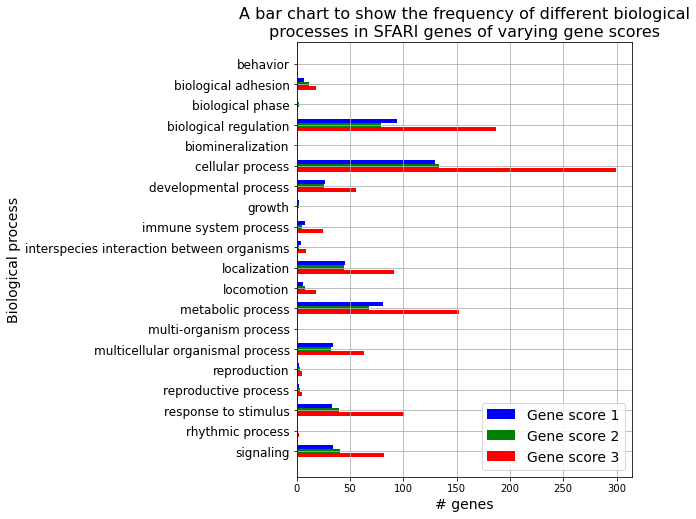

In [17]:
ax = plt.subplot()

s1, s2, s3 = s1.sort_values("2"), s2.sort_values("2"), s3.sort_values("2")

data = [s1, s2, s3]
cat_labels = [s["2"].values for s in data]
num_genes = [s["3"].values for s in data]

og_process_labels = get_all_unique_cats(cat_labels)
all_process_labels = np.array([s[:-13] for s in og_process_labels])

num_ticks = all_process_labels.size

width = 0.2
scale = 1000
offsets = [width, 0, -width]
colours = ["b", "g", "r"]
ticks = np.arange(num_ticks)*-1
plt_labels = ["Gene score 1", "Gene score 2", "Gene score 3"]


for f in range(3):
    f_ticks = get_ticks(cat_labels[f], og_process_labels, ticks)
    ax.barh(f_ticks + offsets[f], width=num_genes[f], height=width, color=colours[f], align="center", label=plt_labels[f])
    
ax.set_yticks(ticks)
ax.set_yticklabels(all_process_labels, fontsize=12)
ax.set_ylabel("Biological process", fontsize=14)
ax.set_xlabel("# genes", fontsize=14)
ax.set_title("A bar chart to show the frequency of different biological\nprocesses in SFARI genes of varying gene scores", fontsize=16)
ax.legend(loc="lower right", fontsize=14)
ax.figure.set_figheight(8)
plt.grid(True)
ax.figure.savefig(f'{os.getcwd()}/results/task1-5-stacked.pdf', dpi=fig.dpi)

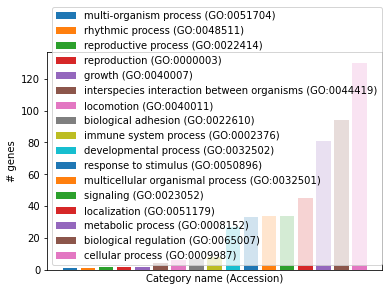

In [308]:
plot_pdb(s1)

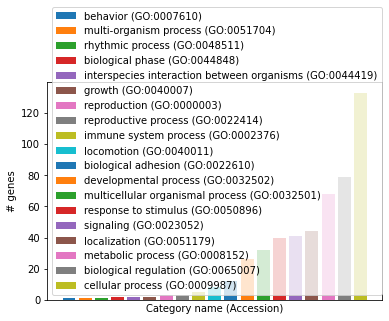

In [273]:
plot_pdb(s2)